# Population by commune

In [1]:
from pynsee.geodata import get_geodata_list, get_geodata

import math
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [3]:
# get geographical data list
geodata_list = get_geodata_list(update=True)

https://data.geopf.fr/wfs?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetCapabilities
Data saved:
/home/onyxia/.cache/pynsee/pynsee/e879822687bab4b12f23762b5d56742b.parquet


In [4]:
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune').to_crs("EPSG:3035")

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/6cb5dc200198fcdb00222fe8b8f7945b.parquet
Creation date: 2025-08-07, today
Set update=True to get the most up-to-date data


In [9]:
com["area"] = com['geometry'].area / 10**6
mapcom = com.to_crs(epsg=3857)

mapcom['REF_AREA'] = 'D' + mapcom['code_insee']
mapcom['density'] = mapcom['population'] / mapcom['area'] 

In [10]:
mapcom2 = mapcom.copy().transform_overseas(
    departement=['971', '972', '974', '973', '976', 'NR'],
    factor=[1.5, 1.5, 1.5, 0.35, 1.5, 1.5],
    startAngle = math.pi * (1 - 2 * 1 / 9))

mapcom2 = mapcom2.zoom(departement = ["75","92", "93", "91", "77", "78", "95", "94"],
                     factor=1.5, startAngle = math.pi * (1 - 3.5 * 1/9))

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/f2bbdea5546ef02791b1286f1b6b1a51.parquet
Creation date: 2025-08-07, today
Set update=True to get the most up-to-date data


In [11]:
mapcom2.loc[mapcom2.density < 40, 'range'] = "< 40"
mapcom2.loc[mapcom2.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 80, 100, 120, 150, 200, 250, 400, 600, 1000, 2000, 5000, 10000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    mapcom2.loc[(mapcom2.density >= min_range) & (mapcom2.density < max_range), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

mapcom2['range'] = mapcom2['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))  

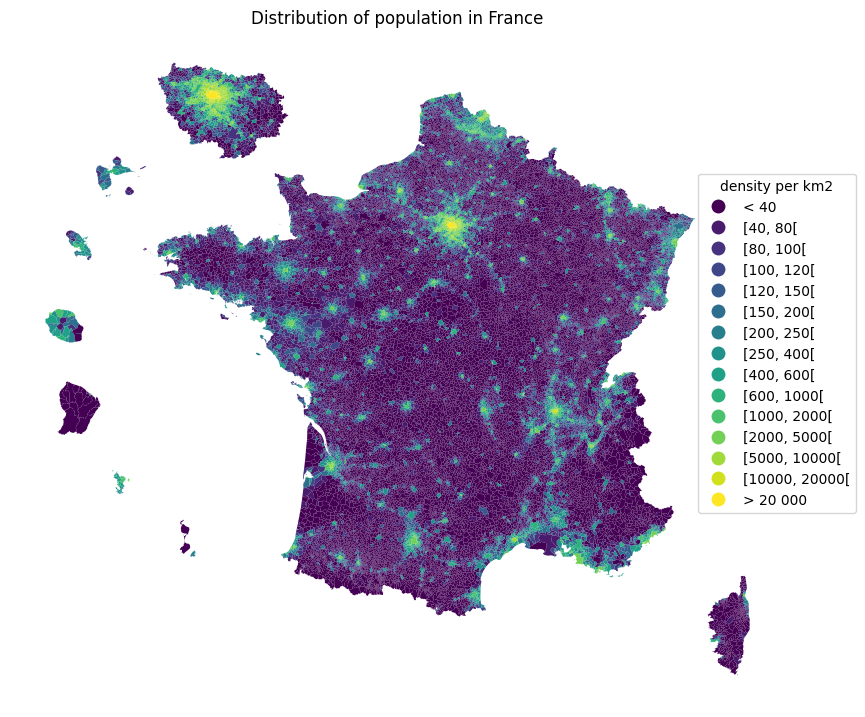

In [12]:
fig, ax = plt.subplots(1,1, figsize=[10,10])
mapcom2.plot(column='range', cmap=cm.viridis,
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in France')
plt.show()
